In [1]:
import ray
import ray.rllib.agents.ppo as ppo
from ray.tune.logger import pretty_print

In [2]:
ray.init()
config = ppo.DEFAULT_CONFIG.copy()
config['num_gpus'] = 0
config['num_workers'] = 1

In [3]:
trainer = ppo.PPOTrainer(config=config, env='CartPole-v0')
for i in range(1000):
    result = trainer.train()
    print(pretty_print(result))

    if i % 100 == 0:
        checkpoint = trainer.save()
        print(f'checkpoint save at {checkpoint}')

2022-07-21 10:58:59,100	INFO trainer.py:2295 -- Your framework setting is 'tf', meaning you are using static-graph mode. Set framework='tf2' to enable eager execution with tf2.x. You may also then want to set eager_tracing=True in order to reach similar execution speed as with static-graph mode.
2022-07-21 10:58:59,102	INFO ppo.py:268 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting simple_optimizer=True if this doesn't work for you.
2022-07-21 10:58:59,103	INFO trainer.py:864 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(RolloutWorker pid=544502) 2022-07-21 10:59:02,378	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dicti

agent_timesteps_total: 4000
custom_metrics: {}
date: 2022-07-21_10-59-10
done: false
episode_len_mean: 24.81366459627329
episode_media: {}
episode_reward_max: 109.0
episode_reward_mean: 24.81366459627329
episode_reward_min: 8.0
episodes_this_iter: 161
episodes_total: 161
experiment_id: 97ba0de45d524ff5b52346614f969764
hostname: dufek-XPS-13
info:
  learner:
    default_policy:
      custom_metrics: {}
      learner_stats:
        cur_kl_coeff: 0.20000000298023224
        cur_lr: 4.999999873689376e-05
        entropy: 0.6680648326873779
        entropy_coeff: 0.0
        kl: 0.026196440681815147
        model: {}
        policy_loss: -0.03886919096112251
        total_loss: 9.027015686035156
        vf_explained_var: -0.06597967445850372
        vf_loss: 9.060644149780273
      num_agent_steps_trained: 128.0
  num_agent_steps_sampled: 4000
  num_agent_steps_trained: 4000
  num_steps_sampled: 4000
  num_steps_trained: 4000
  num_steps_trained_this_iter: 4000
iterations_since_restore: 1
n

: 

In [6]:
# Keras Mulit-Input and Custom Model in RLlib
import tensorflow as tf
from ray.rllib.models.modelv2 import restore_original_dimensions
from ray.rllib.models.tf.misc import normc_initializer
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.policy.sample_batch import SampleBatch
from ray.rllib.utils.typing import ModelConfigDict

import gym

In [7]:
class KerasQModel(TFModelV2):
    "DQN"
    def __init__(self, obs_space: gym.spaces.Space, action_space: gym.spaces.Space, num_outputs: int, model_config: ModelConfigDict, name: str):
        super(KerasQModel, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        original_space = obs_space.original_space if hasattr(obs_space, "original_space") else obs_space
        self.cart = tf.keras.layers.Input(shape=original_space['cart'].shape, name='cart')
        self.pole = tf.keras.layers.Input(shape=original_space['pole'].shape, name='pole')

        # Concatenating the inputs
        concatenated = tf.keras.layers.Concatenate()([self.cart, self.pole])

        # Building the dense (fully-connected) layers
        x = concatenated
        neuron_lst = [ 64, 32, 16, 8, num_outputs]
        for layer_id, nr_neurons in enumerate(neuron_lst):
            x = tf.keras.layers.Dense(nr_neurons, name='dense_layer_' + str(layer_id), activation = tf.nn.relu,
                                    kernel_initializer=normc_initializer(1.0))(x)
                            
        layer_out = x 
        self.model = tf.keras.Model([self.cart, self.pole], layer_out)

    def forward(self, input_dict, state, seq_lens):
        "Custom coreforward method"

In [8]:
import tensorflow as tf
from ray.rllib.models.modelv2 import restore_original_dimensions
from ray.rllib.models.tf.misc import normc_initializer
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from ray.rllib.policy.sample_batch import SampleBatch
import numpy as np

In [63]:
obs_space = {
    'cart': np.array([-4.8, 0]),
    'pole': np.array([-0.418, 0])
}

#print(obs_space['cart'].shape)
#print(obs_space['pole'].shape)

cart = tf.keras.layers.Input(shape=obs_space['cart'].shape, name='cart')
pole = tf.keras.layers.Input(shape=obs_space['pole'].shape, name='pole')
radek = tf.keras.layers.Input(shape=(0,), name='radek')
zadek = tf.keras.layers.Input(shape=(1,), name='zadek')

concatenated = tf.keras.layers.Concatenate()([cart, pole])
concatenated

<tf.Tensor 'concatenate_20/concat:0' shape=(?, 4) dtype=float32>

In [69]:
x = concatenated
num_outputs = 8
neuron_lst = [64, 32, 16, 8, num_outputs]
for layer_id, nr_neurons in enumerate(neuron_lst):
    #print(layer_id, nr_neurons)
    x = tf.keras.layers.Dense(nr_neurons, name='dense_layer_'+str(layer_id), activation=tf.nn.relu, 
                                kernel_initializer=normc_initializer(1.0))(x)

layer_out = x
model = tf.keras.Model([cart, pole], layer_out)
print(model.summary())

inputs = {
    'cart': obs_space['cart'],
    'pole': obs_space['pole']
}

model(inputs)

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cart (InputLayer)              [(None, 2)]          0           []                               
                                                                                                  
 pole (InputLayer)              [(None, 2)]          0           []                               
                                                                                                  
 concatenate_20 (Concatenate)   (None, 4)            0           ['cart[0][0]',                   
                                                                  'pole[0][0]']                   
                                                                                                  
 dense_layer_0 (Dense)          (None, 64)           320         ['concatenate_20[0][0]']  

ValueError: Input 0 of layer "dense_layer_0" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (Dimension(4),)

In [18]:
# Customize Training Procedure -- callback actions
# https://stackoverflow.com/questions/58777068/how-do-we-print-action-distributions-in-rllib-during-training

'obs'

In [49]:
# Computational Graph
import torch

dtype = torch.float
device = torch.device('cpu')

batch_size, inputs, hidden, outputs = 64, 1000, 100, 10
x = torch.randn(batch_size, inputs, device=device, dtype=dtype)
y = torch.randn(batch_size, outputs, device=device, dtype=dtype)

layer1 = torch.randn(inputs, hidden, device=device, dtype=dtype)
layer2 = torch.randn(hidden, outputs, device=device, dtype=dtype)
print(f'layer1, layer2: {layer1.shape, layer2.shape}')
learning_rate = 1e-6

for t in range(500):
    h = x.mm(layer1)
    print(f'h: {h.shape}')
    h_relu = h.clamp(min=0)
    print(f'clamped h: {h_relu.shape}')
    y_pred = h_relu.mm(layer2)
    print(f'layer2 out: {y_pred.shape}')

    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)

    grad_y_pred = 2.0 * (y_pred - y)
    grad_layer2 = h_relu.t().mm(grad_y_pred)
    grad_h_relu = grad_y_pred.mm(layer2.t())
    grad_h = grad_h_relu.clone()
    
    grad_h[h<0] = 0
    grad_layer1 = x.t().mm(grad_h)

    layer1 -= learning_rate * grad_layer1
    layer2 -= learning_rate * grad_layer2


layer1, layer2: (torch.Size([1000, 100]), torch.Size([100, 10]))
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])
clamped h: torch.Size([64, 100])
layer2 out: torch.Size([64, 10])
h: torch.Size([64, 100])


In [16]:
# Torch to DL Graph
import torch

batch_size, inputs, hidden, outputs = 64, 1000, 100, 10

x = torch.randn(batch_size, inputs)
y = torch.randn(batch_size, outputs)

model = torch.nn.Sequential(
    torch.nn.Linear(inputs, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, outputs)
)

loss_fn = torch.nn.MSELoss(reduction='sum')
learning_rate = 1e-4

for t in range(500):
    y_pred = model(x)
    loss = loss_fn(y_pred, y)

    if t % 100 == 0:
        print(t, loss.item())

    model.zero_grad()
    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad


0 641.9111938476562
100 2.742946147918701
200 0.06663484871387482
300 0.002461441792547703
400 0.00012200658966321498


<function matplotlib.pyplot.show(close=None, block=None)>

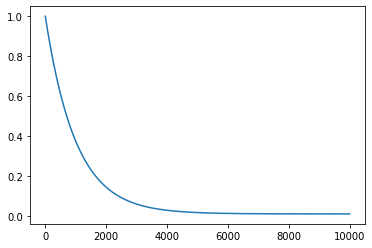

In [17]:
# DQN using Torch
import math, random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F

import matplotlib.pyplot as plt
import gym
import numpy as np
from collections import deque
from tqdm import trange

env_id = "CartPole-v0"
#env_id = 'LunarLander-v2'

env = gym.make(env_id)
epsilon_start = 1.0

epsilon_final = 0.01
epsilon_decay = 1000
eps_by_episode = lambda epoch: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * epoch / epsilon_decay)

plt.plot([eps_by_episode(i) for i in range(10000)])
plt.show





In [18]:
from asyncore import readwrite


class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done

    def __len__(self):
        return len(self.buffer)


class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )

    def forward(self, x):
        return self.layers(x)

    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0),
            volatile=True)
            q_value = self.forward(state)
            action = q_value.max(1)[1].item() # index of the maximul value(s)
        else:
            action = random.randrange(env.action_space.n)
            q_value = None

        return action


model = DQN(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(model.parameters())
replay_buffer = ReplayBuffer(capacity=1000)

episodes = 10000
batch_size = 32
gamma = 0.99
buffer_size = 3000 # DQN will not start training the model until the replay buffer is full
neurons = 192

losses = []
all_rewards = []
episode_reward = 0

state = env.reset()
tot_reward = 0
tr = trange(episodes+1, desc='Agent Training', leave=True)

def compute_td_loss(batch_size):
    state, action, reward, next_state, done  = replay_buffer.sample(batch_size)
    state = autograd.Variable(torch.FloatTensor(np.float32(state)), volatile=True)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action = autograd.Variable(torch.LongTensor(reward))
    reward = autograd.Variable(torch.FloatTensor(reward))
    done = autograd.Variable(torch.FloatTensor(done))

    q_values = model(state)
    next_q_values = model(next_state)
    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)

    next_q_value = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
    
    optimizer.zero_grad() # reset gradients
    loss.backward() # push the loss backwards
    optimizer.step() # make up weights (perform training)

    return loss

def play_game():
    done = False
    state = env.reset()
    while not done:
        action = model.act(state, epsilon_final)
        next_state, reward, done, _ = env.step(action)
        env.render()
        state = next_state

for episode in tr:

    tr.set_description(f"Agent Training: {episode+1} Avg Reward {tot_reward/(episode+1)}")
    tr.refresh()
    epsilon = eps_by_episode(episode)

    action = model.act(state, epsilon)
    next_state, reward, done, _ = env.step(action)

    replay_buffer.push(state, action, reward, next_state, done)
    tot_reward += reward
    state = next_state
    episode_reward += reward

    if done:
        if episode > buffer_size:
            play_game()
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0

    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())

    #if episode % 2000 == 0:
        #plot(episode, all_rewards, losses)



Agent Training: 14 Avg Reward 0.9285714285714286:   0%|          | 0/10001 [00:00<?, ?it/s]/tmp/ipykernel_452925/2002858631.py:38: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0),
Agent Training: 33 Avg Reward 0.9696969696969697:   0%|          | 0/10001 [00:00<?, ?it/s]/tmp/ipykernel_452925/2002858631.py:69: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(np.float32(state)), volatile=True)
/tmp/ipykernel_452925/2002858631.py:70: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
/tmp/ipykernel_452925/2002858631.py:71: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be rem

In [64]:
# action = q_value.max(1)[1].item() # returns only scalar value
q_value = torch.FloatTensor(np.array([[1., -2., 0.], [3., 5., 10.], [3., 5., 0.]]))
#q_value.max(1)[1].item()
q_value.max(1)[1] # returns indexes of maximas

tensor([0, 2, 1])

NameError: name 'ReplayBuffer' is not defined

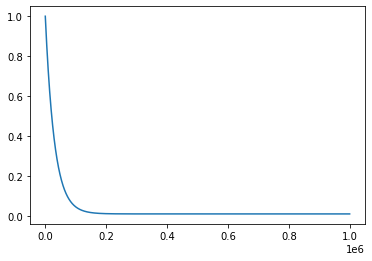

In [14]:
# DDQN -- Double (Dueling) DQN
import wrappers
import matplotlib.pyplot as plt
import math
import torch.optim as optim
import torch.autograd as autograd

env_id = 'PongNoFrameskip-v4'
env = wrappers.make_atari(env_id)
env = wrappers.wrap_deepmind(env)
env = wrappers.wrap_pytorch(env)

epsilon_start = 1.
epsilon_final = 0.01
epsilon_decay = 30000

epsilon_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

plt.plot([epsilon_by_episode(i) for i in range(1000000)])
plt.show

class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()

        self.input_shape = input_shape
        self.num_actions = num_actions

        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)


    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = autograd.Variable(torch.FloatTensor(np.float32(state).unsqueeze(0), volatile=True))
            q_value = self.forward(state)
            action = q_value.max(1)[1].data[0]
        else:
            action = random.randrange(env.action_space.n)
        return action


model = CnnDQN(env.observation_space.shape, env.action_space.n)
optimizer = optim.Adam(model.parameters(), lr=0.00001)

replay_start = 10000
replay_buffer = ReplayBuffer(100000)

episodes = 1400000

if episode % 200000 == 0:
    plot(episode, all_rewards, losses)


In [11]:
# DDQN
from torch import rand


class DDQN(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(DDQN, self).__init__()

        self.feature = nn.Sequential(
            nn.Linear(num_inputs, 128),
            nn.ReLU()
        )

        self.advantage = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_outputs)
        )

        self.value = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        def forward(self, x):
            x = self.feature(x)
            advantage = self.advantage(x)
            value = self.value(x)
            return value + advantage - advantage.mean()

        def act(self, state, epsilon):
            if random.random() > epsilon:
                state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
                q_value = self.forward(state)
                action = q_value.max(1)[1].item()
            else:
                action = random.randrange(env.action_space.n)
            return action

current_model = DDQN(env.observation_space.shape[0], env.action_space.n)
target_model = DDQN(env.observation_space.shape[0], env.action_space.n)

q_values = current_model(state)
next_q_values = target_model(next_state)

q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
next_q_value = next_q_values.max(1)[0]
expected_q_value = reward + gamma * next_q_value * (1 - done)

loss = (q_value - expected_q_value.detach()).pow(2).mean()


NameError: name 'nn' is not defined

In [10]:
# Replay Buffer with Prioritized Experience
from random import sample

from numpy import indices


class NaivePrioritizedBudder(object):
    def __init__(self, capacity, prob_alpha=0.6):
        self.prob_alpha = prob_alpha
        self.capacity = capacity
        self.buffer = []
        self.pos = 0
        self.priorities = np.zeros((capacity), dtype=np.float32)

    def push(self, state, action, reward, next_state, done):
        assert state.ndim == next_state.ndim
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        max_prio = self.priorities.max() if self.buffer else 1.0

        if len(self.buffer) < self.capacity:
            self.buffer.append((state, action, reward, next_state, done))
        else:
            self.buffer[self.pos] = (state, action, reward, next_state, done)

        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.buffer) == self.capacity:
            prios = self.priorities
        else:
            prios = self.priorities[:self.pos]

        probs = prios ** self.prob_alpha
        probs /= probs.sum()

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        samples = [ self.buffer[idx] for idx in indices ]

        total = len(self.buffer)
        weights = (total * probs[indices]) ** (-beta)
        weights /= weights.max()
        weights = np.array(weights, dtype=np.float32)

        batch = list(zip(*samples))
        states = np.concatenate(batch[0])
        actions = batch[1]
        rewards = batch[2]
        next_states = np.concatenate(batch[3])
        dones = batch[4]

        return states, actions, rewards, next_states, dones, indices, weights

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, prio in zip(list(batch_indices), [batch_priorities]):
            self.priorities[idx] = prio

    def __len__(self):
        return len(self.buffer)

beta_start = 0.4
beta_episodes = episodes / 10
beta_by_episode = lambda episode: min(1., beta_start + episode * (1. - beta_start) / beta_episodes)

plt.plot([beta_by_episode(i) for i in range(episodes)])

def compute_td_loss(batch_size, beta):
    state, action, reward, next_state, done, indices, weights = replay_buffer.sample(batch_size, beta)

    state = autograd.Variable(torch.FloatTensor(np.float32(state)))
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)))
    action = autograd.Variable(torch.LongTensor(action))
    reward = autograd.Variable(torch.FloatTensor(reward))
    done = autograd.Variable(torch.FloatTensor(done))
    weights = autograd.Variable(torch.FloatTensor(weights))

    q_values = current_model(state)
    next_q_values = target_model(next_state)

    q_value = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (q_value - expected_q_value.detach()).pow(2).mean()
    prios = loss + 1e-5
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    replay_buffer.update_priorities(indices, prios.data.cpu().numpy())
    optimizer.step()

if done:
    if episode > buffer_size and avg_reward > min_play_reward:
        play_game()
    state = env.reset()
    all_rewards.append(episode_reward)
    episode_reward = 0

if len(replay_buffer) > batch_size:
    beta = beta_by_episode(episode)
    loss = compute_td_loss(batch_size, beta)
    losses.append(loss.item())

SyntaxError: invalid syntax (1047347126.py, line 75)

In [9]:
    env.observation_space.shape

(1, 84, 84)

In [69]:
# POLICY GRADIENT METHODS
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
# sampling out action space from continuous probability back to discrete action value
from torch.distributions import Categorical 
import torch.optim as optim

In [39]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
#Hyperparameters

learning_rate = 0.0002
gamma = 0.98

class REINFORCE(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(REINFORCE, self).__init__()
        
        self.data = []
        self.fc1 = nn.Linear(input_shape, 128)
        self.fc2 = nn.Linear(128, num_actions)
        self.optimizer = optim.Adam(self.parameters(),
        lr=learning_rate)

    def act(self, x):

        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x.clone()), dim=0)

        return x

    def put_data(self, item):
        self.data.append(item)
        
    def train_net(self):

        R = 0
        for r, log_prob in self.data[::-1]:
            print(f'From train_net: {type(r)}, {type(log_prob)}')
            R = r + gamma * R
            loss = -log_prob * R
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        self.data = []

env = gym.make('LunarLander-v2')
pi = REINFORCE(env.observation_space.shape[0], env.action_space.n)
score = 0.0
print_interval = 100
iterations = 10000
min_play_reward = 20

def play_game():

    done = False
    state = env.reset()
    its = 500
    while(not done and its > 0):
        its -= 1
        prob = pi.act(torch.from_numpy(state).float())
        m = Categorical(prob)
        action = m.sample()
        next_state, reward, done, _ = env.step(action.item())
        env.render()
        state = next_state

for iteration in range(iterations):
    s = env.reset()
    for t in range(101):
        prob = pi.act(torch.from_numpy(s).float())
        m = Categorical(prob)
        action = m.sample()
        print(f'actionL {action}')
        s_prime, r, done, info = env.step(action.item())
        log_prob = torch.log(prob[action])
        pi.put_data((r, log_prob))
        print(f'Log Prob: {torch.log(prob[action])}')
        s = s_prime
        score += r
        if done:
            if score/print_interval > min_play_reward:
                play_game()
            break
        pi.train_net()
        if iteration%print_interval==0 and iteration!=0:
            print("# of episode :{}, avg score : {}".format(iteration, score/print_interval))
        score = 0.0
env.close()

actionL 2
Log Prob: -1.459815502166748
From train_net: <class 'numpy.float64'>, <class 'torch.Tensor'>
actionL 0
Log Prob: -1.2035449743270874
From train_net: <class 'numpy.float64'>, <class 'torch.Tensor'>
actionL 2
Log Prob: -1.4747905731201172
From train_net: <class 'numpy.float64'>, <class 'torch.Tensor'>
actionL 3
Log Prob: -1.4127229452133179
From train_net: <class 'numpy.float64'>, <class 'torch.Tensor'>
actionL 0
Log Prob: -1.2032055854797363
From train_net: <class 'numpy.float64'>, <class 'torch.Tensor'>
actionL 1
Log Prob: -1.4678841829299927
From train_net: <class 'numpy.float64'>, <class 'torch.Tensor'>
actionL 2
Log Prob: -1.497996211051941
From train_net: <class 'numpy.float64'>, <class 'torch.Tensor'>
actionL 3
Log Prob: -1.4036810398101807
From train_net: <class 'numpy.float64'>, <class 'torch.Tensor'>
actionL 0
Log Prob: -1.2036086320877075
From train_net: <class 'numpy.float64'>, <class 'torch.Tensor'>
actionL 3
Log Prob: -1.4006272554397583
From train_net: <class 'nu

/home/dufek/.virtualenvs/rayrl/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Error detected in MvBackward0. Traceback of forward call that caused the error:
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/dufek/.virtualenvs/rayrl/lib/python3.8/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/dufek/.virtualenvs/rayrl/lib/python3.8/site-packages/traitlets/config/application.py", line 976, in launch_instance
    app.start()
  File "/home/dufek/.virtualenvs/rayrl/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/home/dufek/.virtualenvs/rayrl/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [4, 128]], which is output 0 of AsStridedBackward0, is at version 169; expected version 168 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!